# Explore cell type bias due to different growth rates in the clone distributions in the T-cell project by resampling at observing the effect on multitime clones

In [11]:
import os, sys
parent_dir = os.path.abspath('..')

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [12]:
import numpy as np
import anndata
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib
import random
import clone_validation.src as src

In [13]:
home = os.path.expanduser("~")
ADATA_PATH = os.path.join(home, 'tcell_induction/data/adata/LBC-EHT-sep-reg-ccreg-ct-update-sigs-added-w-mincut-clones.h5ad')

# Specify the starting and ending timepoints of interest
t1 = 5
t2 = 10
times = [t1, t2]

In [14]:
matplotlib.rcParams.update({'font.size': 16})

## Load the data

In [15]:
# Load data from the lineage barcoding experiment
adata = anndata.read_h5ad(ADATA_PATH)

# Reduce to just the data from t=t1 to t=t2
order_filter = adata.obs.index[adata.obs.Order.apply(lambda x: x in times)]

adata = adata[order_filter]

In [16]:
cell_types = list(adata.obs['Cell Types'].unique())
print(cell_types)

['Progenitor Cells', 'Myeloid Cells', 'Erythroid Cells', 'Mast Cells', 'Endothelial Cells', 'ProT Cells']


In [17]:
# Assign colors by cell type for plotting
celltype_color = {'Endothelial Cells': 'tab:green',
                  'Erythroid Cells': 'tab:red',
                  'Myeloid Cells': 'tab:orange',
                  'Mast Cells': 'xkcd:maroon',
                  'ProT Cells': 'tab:cyan',
                  'Progenitor Cells': 'tab:grey'}


# Create the legend for the color dictionary
def lineage_elem(lin, color_dict):
    return Line2D([0], [0], marker='o', color='w', label=lin, markerfacecolor=color_dict[lin], markersize=10)

celltype_legend_handles = [lineage_elem(lin, celltype_color) for lin in celltype_color.keys()]

## Estimate growth rates using gene signature scores

In [18]:
# Define logistic function to estimate birth/death rates from signature scores
def logistic(x, L, k, x0=0):
    f = L / (1 + np.exp(-k * (x - x0)))
    return f

def gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width):
    return beta_min + logistic(p, L=beta_max - beta_min, k=4 / width, x0=center)

def beta(p, beta_max=1.7, beta_min=0.3, pmax=1.0, pmin=-0.5, center=0.25):
    return gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width=0.5)

def delta(a, delta_max=1.7, delta_min=0.3, amax=0.5, amin=-0.4, center=0.1):
    return gen_logistic(a, delta_max, delta_min, amax, amin, center,
                          width=0.2)

In [19]:
# Calculate birth/death rates by cell
birth = beta(adata.obs['G2M'])
death = delta(adata.obs['Apoptosis'])

# Calculate the growth 
adata.obs['growth'] = np.exp(birth-death)

Trying to set attribute `.obs` of view, copying.


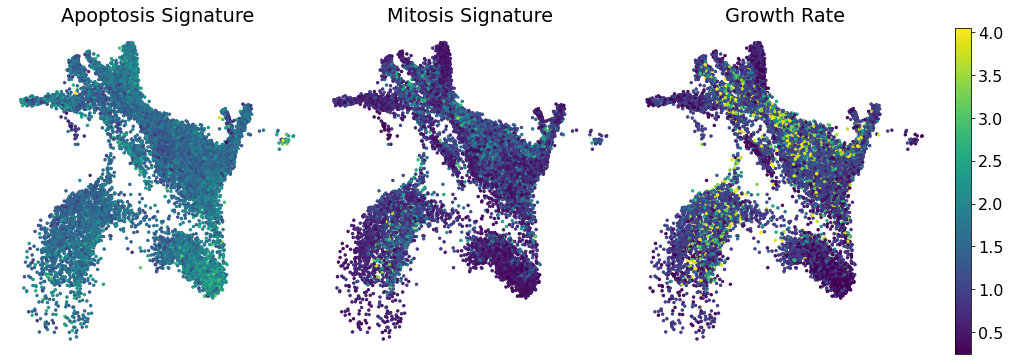

In [20]:
# Plot the growth rates compared to the two signatures
fig = plt.figure(figsize=(18,6))
gs= fig.add_gridspec(1,13)
plt.subplot(gs[0, :4])
plt.title('Apoptosis Signature')
plt.axis('off')
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], c=adata.obs['Apoptosis'], s=6)

plt.subplot(gs[0, 4:8])    
plt.title('Mitosis Signature')
plt.axis('off')
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], c=adata.obs['G2M'], s=6)

plt.subplot(gs[0, 8:])
plt.title('Growth Rate')
plt.axis('off')
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], c=adata.obs['growth'], s=6)
plt.colorbar()
plt.show()

In [21]:
# Compute the mean growth rate for each cell type between the two timepoints of interest
normalize = False
growth_rates = np.zeros((len(times), len(cell_types)))
growth_rates_sd = np.zeros((len(times), len(cell_types)))
for i in range(len(times)):
    for j in range(len(cell_types)):
        t = times[i]
        c = cell_types[j]
        cells_in_c_at_t = adata[(adata.obs['Order'] == t) & (adata.obs['Cell Types'] == c)]
        
        growth_t1_t2 = cells_in_c_at_t.obs['growth'].pow(t2-t1)
        
        growth_rates[i, j] = growth_t1_t2.mean()
        growth_rates_sd[i, j] = growth_t1_t2.std()
        
    if normalize:
        growth_rates[i] /= np.sum(growth_rates[i])

growth_rates_adata = anndata.AnnData(X=growth_rates, obs={'Order': times}, var={'Cell Types': cell_types})
growth_rates_adata.obs.set_index('Order', inplace=True)
growth_rates_adata.var.set_index('Cell Types', inplace=True)

growth_rates_df = growth_rates_adata.to_df()

growth_rates_sd_adata = anndata.AnnData(X=growth_rates_sd, obs={'Order': times}, var={'Cell Types': cell_types})
growth_rates_sd_adata.obs.set_index('Order', inplace=True)
growth_rates_sd_adata.var.set_index('Cell Types', inplace=True)

growth_rates_sd_df = growth_rates_sd_adata.to_df()

In [22]:
growth_rates_df

Cell Types,Progenitor Cells,Myeloid Cells,Erythroid Cells,Mast Cells,Endothelial Cells,ProT Cells
Order,,,,,,
5,142.549667,95.787148,136.370468,99.117027,55.398075,996.686890
10,7.820026,58.438820,55.656719,14.464264,NaN,118.215019


In [23]:
growth_rates_sd_df

Cell Types,Progenitor Cells,Myeloid Cells,Erythroid Cells,Mast Cells,Endothelial Cells,ProT Cells
Order,,,,,,
5,288.351532,239.765274,291.917145,230.173615,216.037766,NaN
10,65.949989,198.034653,209.856415,94.838982,NaN,273.970795


## Compute the observed cell type distributions

In [28]:
# Print the number of clones, multi-cell clones and multi-time clones
print("Number of clones = ", adata.obsm['X_clone'].shape[1])

# Filter to retain only clones which contain at least 2 cells
# (clones with only one cell contribute no lineage information)
clones_filtered = []
clones_filtered_t1 = []
clones_filtered_t2 = []
clones_filtered_multitime = []
for b in range(adata.obsm['X_clone'].shape[1]):
    cell_indicies_with_b = adata.obsm['X_clone'][:,b].nonzero()[0]
    if cell_indicies_with_b.shape[0] > 1:
        clones_filtered.append(b)
        
        times_b = set(adata[cell_indicies_with_b].obs['Order'])
        if t1 in times_b:
            cell_indicies_with_b_t1 = adata[adata.obs.Order == t1].obsm['X_clone'][:,b].nonzero()[0]
            if len(cell_indicies_with_b_t1) > 1: # multiple cells in clone at t=t1
                clones_filtered_t1.append(b)
            
        if t2 in times_b:
            cell_indicies_with_b_t2 = adata[adata.obs.Order == t2].obsm['X_clone'][:,b].nonzero()[0]
            if len(cell_indicies_with_b_t2) > 1: # multiple cells in clone at t=t2
                clones_filtered_t2.append(b)
        
        if len(times_b) > 1:
            clones_filtered_multitime.append(b)
            
        
print("Number of clones containing more than one cell = ", len(clones_filtered))
print("Number of clones appearing at both timepoints = ", len(clones_filtered_multitime))

Number of clones =  1465
Number of clones containing more than one cell =  1356
Number of clones appearing at both timepoints =  268


In [29]:
# Extract the subset with just the clones
index_w_clones = list(set(adata.obsm['X_clone'].nonzero()[0]))
clone_filter = adata.obs.index[index_w_clones]
adata_clones = adata[clone_filter]

# Extract the subset with just the clones shared by more than one cell
index_w_multicell_clones = list(set(adata.obsm['X_clone'][:, clones_filtered].nonzero()[0]))
multicell_clone_filter = adata.obs.index[index_w_multicell_clones]
adata_clones_multicell = adata_clones[multicell_clone_filter]

# Extract the subset with just the clones shared by more than one cell at multiple timepoints
index_w_multitime_clones = list(set(adata.obsm['X_clone'][:, clones_filtered_multitime].nonzero()[0]))
multitime_clone_filter = adata.obs.index[index_w_multitime_clones]
adata_clones_multitime = adata_clones_multicell[multitime_clone_filter]

In [30]:
# Sampling parameters inherent to the dataset
r = {str(t1): 7951/26500, str(t2): 4691/232400}
b = {str(t1): 2189/7951, str(t2): 1784/4691}
rb = {}
rb[str(t1)] = r[str(t1)]*b[str(t1)]
rb[str(t2)] = r[str(t2)]*b[str(t2)]

print("From experimental dataset: \n")
print("\t sampling rate, r =", r)
print("\t combined barcoding and barcode detection rate, b =", b)
print("\t combined sampling rate, rb =", rb)

From experimental dataset: 

	 sampling rate, r = {'5': 0.30003773584905663, '10': 0.02018502581755594}
	 combined barcoding and barcode detection rate, b = {'5': 0.2753112815997988, '10': 0.3803027073118738}
	 combined sampling rate, rb = {'5': 0.08260377358490567, '10': 0.007676419965576593}


In [31]:
# Add the sampling rates to the anndata object
adata.obs['rb'] = adata.obs.Order.apply(lambda x: rb[str(x)])

In [32]:
# Create a cell census dataframe for the two timepoints for the entire population, just the multicell clones
# and just the multitime clones
normalized = False
census_df = pd.DataFrame({'Endothelial Cells': [],'Erythroid Cells': [],'Myeloid Cells': [],
                          'Mast Cells': [],'ProT Cells': [], 'Progenitor Cells': []})
population_adatas = {
#     "total - LBC + timecourse": adata, 
                     "Total sample": adata[adata.obs.dataset != 'timecourse'], 
                     "multicell": adata_clones_multicell, 
                     "multitime": adata_clones_multitime}
census_dfs = dict(zip(population_adatas.keys(), [census_df, census_df, census_df, census_df]))
                     

for k in population_adatas:
    for t in [t1, t2]:
        data = population_adatas[k].obs[population_adatas[k].obs.Order == t]
        if normalized:
            census_dfs[k] = census_dfs[k].append({'Order': t, 
                                          'Endothelial Cells': data[data['Cell Types'] == 'Endothelial Cells'].shape[0]/data.shape[0], 
                                          'Erythroid Cells': data[data['Cell Types'] == 'Erythroid Cells'].shape[0]/data.shape[0], 
                                          'Myeloid Cells': data[data['Cell Types'] == 'Myeloid Cells'].shape[0]/data.shape[0],
                                          'Mast Cells': data[data['Cell Types'] == 'Mast Cells'].shape[0]/data.shape[0], 
                                          'ProT Cells': data[data['Cell Types'] == 'ProT Cells'].shape[0]/data.shape[0], 
                                          'Progenitor Cells': data[data['Cell Types'] == 'Progenitor Cells'].shape[0]/data.shape[0]},
                                        ignore_index = True)
        else:
            census_dfs[k] = census_dfs[k].append({'Order': t, 
                                          'Endothelial Cells': data[data['Cell Types'] == 'Endothelial Cells'].shape[0], 
                                          'Erythroid Cells': data[data['Cell Types'] == 'Erythroid Cells'].shape[0], 
                                          'Myeloid Cells': data[data['Cell Types'] == 'Myeloid Cells'].shape[0],
                                          'Mast Cells': data[data['Cell Types'] == 'Mast Cells'].shape[0], 
                                          'ProT Cells': data[data['Cell Types'] == 'ProT Cells'].shape[0], 
                                          'Progenitor Cells': data[data['Cell Types'] == 'Progenitor Cells'].shape[0]},
                                        ignore_index = True)
            

    census_dfs[k] = census_dfs[k].set_index('Order')
    print("\n CELL CENSUS: {}".format(k))
    print(census_dfs[k].to_string())


 CELL CENSUS: Total sample
       Endothelial Cells  Erythroid Cells  Myeloid Cells  Mast Cells  ProT Cells  Progenitor Cells
Order                                                                                             
5.0                 36.0            487.0         2309.0        70.0         1.0            5041.0
10.0                 0.0            131.0         1226.0      1423.0      1736.0             182.0

 CELL CENSUS: multicell
       Endothelial Cells  Erythroid Cells  Myeloid Cells  Mast Cells  ProT Cells  Progenitor Cells
Order                                                                                             
5.0                  2.0            143.0          772.0        22.0         0.0            1218.0
10.0                 0.0             49.0          497.0       465.0       648.0              38.0

 CELL CENSUS: multitime
       Endothelial Cells  Erythroid Cells  Myeloid Cells  Mast Cells  ProT Cells  Progenitor Cells
Order                          

In [33]:
# Print the total number of cells in each group as a dataframe
n_cell_df = pd.DataFrame(dict(zip(
    population_adatas.keys(), [[] for i in range(len(population_adatas.keys()))])))
n_cell_df.insert(0, 'Order', [])
n_cell_df = n_cell_df.set_index('Order')

for t in [t1, t2]:
    row = []
    for k in population_adatas:
        data = population_adatas[k][population_adatas[k].obs.Order == t]
        n_cells = data.n_obs
        row.append(int(n_cells))
    n_cell_df.loc[int(t)] = row
    
n_cell_df

,Total sample,multicell,multitime
Order,,,
5,7944.0,2157.0,369.0
10,4698.0,1697.0,462.0


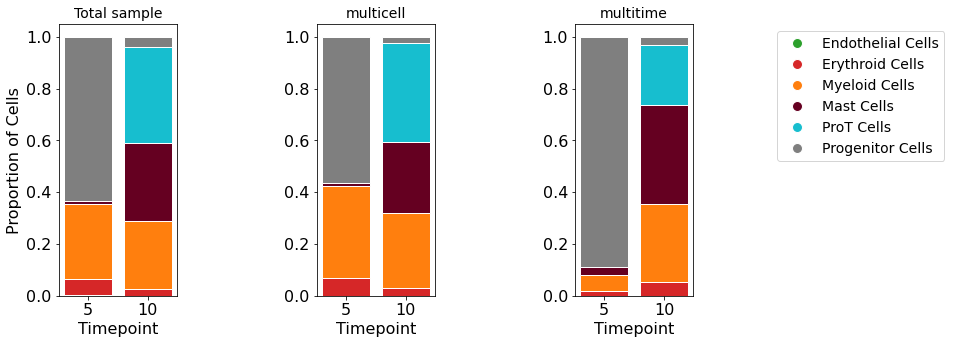

In [34]:
# Compare the cell censuses visually
fig = plt.figure(figsize=(16,5))
# plt.suptitle("Cell Census", fontweight='bold')
fig.tight_layout()
gs = fig.add_gridspec(1, 14)
i = 1


for k in census_dfs:
    plt.subplot(gs[:, 4*(i-1):4*i-2])
    baseline = np.zeros(2)
    plt.xlabel('Timepoint')
    
    # Just plot labels once
    if i == 1:
        plt.ylabel('Proportion of Cells')
    elif i == 3:
        plt.xlabel('Timepoint')
    
    # Plot the cell census
    plt.title("{}".format(k), fontsize=14)
    plt.xticks(range(2), [t1, t2])
    data = census_dfs[k]
    data = data.divide(data.sum(axis=1), axis="rows")
    for lin in data.columns:
        plt.bar(range(2), data.loc[:, lin], facecolor=celltype_color[lin], edgecolor='w', label=lin, bottom=baseline)
        baseline = baseline + data.loc[:, lin]
    i += 1

# Plot the legend
plt.subplot(gs[:, -1])
plt.axis('off')
plt.legend(handles=celltype_legend_handles, fontsize=14)

plt.show()

## Compare the observed and predicted multitime cell censuses

In [36]:
# Generate the predicted multitime cell census
census_df = pd.DataFrame({'Endothelial Cells': [],'Erythroid Cells': [],'Myeloid Cells': [],
                          'Mast Cells': [],'ProT Cells': [], 'Progenitor Cells': []})

k = 'Total sample'
temp_adata_t1 = population_adatas[k][population_adatas[k].obs.Order == t1]
temp_adata_t2 = population_adatas[k][population_adatas[k].obs.Order == t2]

p_dict = src.probability_cell_of_type_given_multitime(population_adatas[k], times, 
                                                      sampling_rate_t1 = temp_adata_t1.obs['rb'].unique()[0],
                                                      sampling_rate_t2 = temp_adata_t2.obs['rb'].unique()[0])
for t in times:
    data = population_adatas[k].obs[population_adatas[k].obs.Order == t]
    if t == t1:
        census_df = census_df.append({'Order': t, 
                                      'Endothelial Cells': p_dict['Endothelial Cells'], 
                                      'Erythroid Cells': p_dict['Erythroid Cells'], 
                                      'Myeloid Cells': p_dict['Myeloid Cells'],
                                      'Mast Cells': p_dict['Mast Cells'], 
                                      'ProT Cells': p_dict['ProT Cells'], 
                                      'Progenitor Cells': p_dict['Progenitor Cells']},
                                    ignore_index = True)
    else:
        census_df = census_df.append({'Order': t, 
                                      'Endothelial Cells': 0, 
                                      'Erythroid Cells': 0, 
                                      'Myeloid Cells': 0,
                                      'Mast Cells': 0, 
                                      'ProT Cells': 0, 
                                      'Progenitor Cells': 0},
                                    ignore_index = True)
            

    census_dfs['Predicted multitime'] = census_df.set_index('Order')
    print("\n CELL CENSUS: {}".format('Predicted multitime'))
    print(census_dfs['Predicted multitime'].to_string())


 CELL CENSUS: Predicted multitime
       Endothelial Cells  Erythroid Cells  Myeloid Cells  Mast Cells  ProT Cells  Progenitor Cells
Order                                                                                             
5.0             0.002801         0.062811       0.255358     0.00809    0.000161          0.670778

 CELL CENSUS: Predicted multitime
       Endothelial Cells  Erythroid Cells  Myeloid Cells  Mast Cells  ProT Cells  Progenitor Cells
Order                                                                                             
5.0             0.002801         0.062811       0.255358     0.00809    0.000161          0.670778
10.0            0.000000         0.000000       0.000000     0.00000    0.000000          0.000000


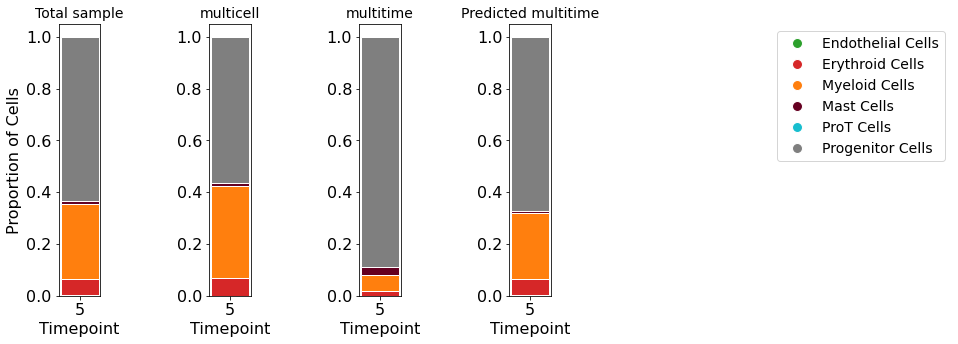

In [37]:
# Compare the cell censuses visually
fig = plt.figure(figsize=(16,5))
# plt.suptitle("Cell Census", fontweight='bold')
fig.tight_layout()
gs = fig.add_gridspec(1, 18)
i = 1


for k in census_dfs:
    plt.subplot(gs[:, 3*(i-1):3*i-2])
    baseline = np.zeros(2)
    plt.xlabel('Timepoint')
    
    # Just plot labels once
    if i == 1:
        plt.ylabel('Proportion of Cells')
    elif i == 3:
        plt.xlabel('Timepoint')
    
    # Plot the cell census
    plt.title("{}".format(k), fontsize=14)
    plt.xticks(range(1), [t1])
    data = census_dfs[k]
    if k != 'Predicted multitime':
        data = data.divide(data.sum(axis=1), axis="rows")
    for lin in data.columns:
        plt.bar(range(1), data.loc[t1, lin], facecolor=celltype_color[lin], edgecolor='w', label=lin, bottom=baseline)
        baseline = baseline + data.loc[t1, lin]
    i += 1

# Plot the legend
plt.subplot(gs[:, -1])
plt.axis('off')
plt.legend(handles=celltype_legend_handles, fontsize=14)

plt.show()

### Try resampling once and exploring cell census in-depth

In [38]:
# Try one re-sampling
adata_sampled = src.randomly_sample_timepoints(adata, times, rate=0.3)

In [39]:
adata_sampled

View of AnnData object with n_obs × n_vars = 4139 × 18529
    obs: 'Cluster', 'Pool', 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'dataset', 'Cell Types', 'Lineage Potential', 'celltype_color', 'Order', 'dataset_color', 'Cell Types - Updated', 'batch', 'Timepoint', 'G1_S', 'G2_M', 'G1S', 'G2M', 'Apoptosis', 'G1/G2 Combined', 'Clone_label', 'growth', 'rb'
    var: 'gene_ids', 'feature_types', 'genome-T1', 'highly_variable-T1', 'means-T1', 'genome-T2', 'highly_variable-T2', 'means-T2', 'genome-timecourse', 'n_cells-timecourse', 'mt-timecourse', 'n_cells_by_counts-timecourse', 'mean_counts-timecourse', 'pct_dropout_by_counts-timecourse', 'total_counts-timecourse', 'highly_variable-timecourse', 'means-timecourse', 'dispersions-timecourse', 'dispersions_norm-timecourse', 'dispersions-T1-0', 'dispersions_norm-T1-0', 'dispersions-T2-0', 'dispersions_norm-T2-0', 'dispersions-T1-1', 'dispersions_norm-T1-1', 'dispersions-T2-1', 'dispe

In [40]:
clone_idx = range(adata_sampled.obsm['X_clone'].shape[1])
adata_multitime_sampled = src.retain_multitime_only(adata_sampled, times, clone_idx)

In [41]:
adata_multitime_sampled

View of AnnData object with n_obs × n_vars = 73 × 18529
    obs: 'Cluster', 'Pool', 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'dataset', 'Cell Types', 'Lineage Potential', 'celltype_color', 'Order', 'dataset_color', 'Cell Types - Updated', 'batch', 'Timepoint', 'G1_S', 'G2_M', 'G1S', 'G2M', 'Apoptosis', 'G1/G2 Combined', 'Clone_label', 'growth', 'rb'
    var: 'gene_ids', 'feature_types', 'genome-T1', 'highly_variable-T1', 'means-T1', 'genome-T2', 'highly_variable-T2', 'means-T2', 'genome-timecourse', 'n_cells-timecourse', 'mt-timecourse', 'n_cells_by_counts-timecourse', 'mean_counts-timecourse', 'pct_dropout_by_counts-timecourse', 'total_counts-timecourse', 'highly_variable-timecourse', 'means-timecourse', 'dispersions-timecourse', 'dispersions_norm-timecourse', 'dispersions-T1-0', 'dispersions_norm-T1-0', 'dispersions-T2-0', 'dispersions_norm-T2-0', 'dispersions-T1-1', 'dispersions_norm-T1-1', 'dispersions-T2-1', 'dispers

In [42]:
# Print the number of clones, multi-cell clones and multi-time clones
print("Number of clones = ", adata_sampled.obsm['X_clone'].shape[1])

# Filter to retain only clones which contain at least 2 cells
# (clones with only one cell contribute no lineage information)
clones_filtered = []
clones_filtered_t1 = []
clones_filtered_t2 = []
clones_filtered_multitime = []
for b in range(adata_sampled.obsm['X_clone'].shape[1]):
    cell_indicies_with_b = adata_sampled.obsm['X_clone'][:,b].nonzero()[0]
    if cell_indicies_with_b.shape[0] > 1:
        clones_filtered.append(b)
        
        times_b = set(adata_sampled[cell_indicies_with_b].obs['Order'])
        if t1 in times_b:
            cell_indicies_with_b_t1 = adata_sampled[adata_sampled.obs.Order == t1].obsm['X_clone'][:,b].nonzero()[0]
            if len(cell_indicies_with_b_t1) > 1: # multiple cells in clone at t=t1
                clones_filtered_t1.append(b)
            
        if t2 in times_b:
            cell_indicies_with_b_t2 = adata_sampled[adata_sampled.obs.Order == t2].obsm['X_clone'][:,b].nonzero()[0]
            if len(cell_indicies_with_b_t2) > 1: # multiple cells in clone at t=t2
                clones_filtered_t2.append(b)
        
        if len(times_b) > 1:
            clones_filtered_multitime.append(b)
            
        
print("Number of clones containing more than one cell = ", len(clones_filtered))
print("Number of clones appearing at both timepoints = ", len(clones_filtered_multitime))

Number of clones =  1465
Number of clones containing more than one cell =  252
Number of clones appearing at both timepoints =  32


In [43]:
# Extract the subset with just the clones
index_w_clones = list(set(adata_sampled.obsm['X_clone'].nonzero()[0]))
clone_filter = adata_sampled.obs.index[index_w_clones]
adata_clones = adata_sampled[clone_filter]

# Extract the subset with just the clones shared by more than one cell
index_w_multicell_clones = list(set(adata_sampled.obsm['X_clone'][:, clones_filtered].nonzero()[0]))
multicell_clone_filter = adata_sampled.obs.index[index_w_multicell_clones]
adata_clones_multicell = adata_clones[multicell_clone_filter]

# Extract the subset with just the clones shared by more than one cell at multiple timepoints
index_w_multitime_clones = list(set(adata_sampled.obsm['X_clone'][:, clones_filtered_multitime].nonzero()[0]))
multitime_clone_filter = adata_sampled.obs.index[index_w_multitime_clones]
adata_clones_multitime = adata_clones_multicell[multitime_clone_filter]

In [44]:
# Create a cell census dataframe for the two timepoints for the entire population, just the multicell clones
# and just the multitime clones
normalized = False
census_df = pd.DataFrame({'Endothelial Cells': [],'Erythroid Cells': [],'Myeloid Cells': [],
                          'Mast Cells': [],'ProT Cells': [], 'Progenitor Cells': []})
population_adatas = {
#     "total - LBC + timecourse": adata, 
                     "Total sample": adata_sampled[adata_sampled.obs.dataset != 'timecourse'], 
                     "In multicell clones": adata_clones_multicell, 
                     "In multitime clones": adata_clones_multitime}
census_dfs = dict(zip(population_adatas.keys(), [census_df, census_df, census_df, census_df]))
                     

for k in population_adatas:
    for t in [t1, t2]:
        data = population_adatas[k].obs[population_adatas[k].obs.Order == t]
        if normalized:
            census_dfs[k] = census_dfs[k].append({'Order': t, 
                                          'Endothelial Cells': data[data['Cell Types'] == 'Endothelial Cells'].shape[0]/data.shape[0], 
                                          'Erythroid Cells': data[data['Cell Types'] == 'Erythroid Cells'].shape[0]/data.shape[0], 
                                          'Myeloid Cells': data[data['Cell Types'] == 'Myeloid Cells'].shape[0]/data.shape[0],
                                          'Mast Cells': data[data['Cell Types'] == 'Mast Cells'].shape[0]/data.shape[0], 
                                          'ProT Cells': data[data['Cell Types'] == 'ProT Cells'].shape[0]/data.shape[0], 
                                          'Progenitor Cells': data[data['Cell Types'] == 'Progenitor Cells'].shape[0]/data.shape[0]},
                                        ignore_index = True)
        else:
            census_dfs[k] = census_dfs[k].append({'Order': t, 
                                          'Endothelial Cells': data[data['Cell Types'] == 'Endothelial Cells'].shape[0], 
                                          'Erythroid Cells': data[data['Cell Types'] == 'Erythroid Cells'].shape[0], 
                                          'Myeloid Cells': data[data['Cell Types'] == 'Myeloid Cells'].shape[0],
                                          'Mast Cells': data[data['Cell Types'] == 'Mast Cells'].shape[0], 
                                          'ProT Cells': data[data['Cell Types'] == 'ProT Cells'].shape[0], 
                                          'Progenitor Cells': data[data['Cell Types'] == 'Progenitor Cells'].shape[0]},
                                        ignore_index = True)
            

    census_dfs[k] = census_dfs[k].set_index('Order')
    print("\n CELL CENSUS: {}".format(k))
    print(census_dfs[k].to_string())


 CELL CENSUS: Total sample
       Endothelial Cells  Erythroid Cells  Myeloid Cells  Mast Cells  ProT Cells  Progenitor Cells
Order                                                                                             
5.0                 10.0            147.0          720.0        20.0         0.0            1479.0
10.0                 0.0             43.0          367.0       407.0       518.0              61.0

 CELL CENSUS: In multicell clones
       Endothelial Cells  Erythroid Cells  Myeloid Cells  Mast Cells  ProT Cells  Progenitor Cells
Order                                                                                             
5.0                  0.0             24.0          107.0         3.0         0.0             135.0
10.0                 0.0             10.0          100.0        65.0       136.0               3.0

 CELL CENSUS: In multitime clones
       Endothelial Cells  Erythroid Cells  Myeloid Cells  Mast Cells  ProT Cells  Progenitor Cells
Order      

In [45]:
# Print the total number of cells in each group as a dataframe
n_cell_df = pd.DataFrame(dict(zip(
    population_adatas.keys(), [[] for i in range(len(population_adatas.keys()))])))
n_cell_df.insert(0, 'Order', [])
n_cell_df = n_cell_df.set_index('Order')

for t in [t1, t2]:
    row = []
    for k in population_adatas:
        data = population_adatas[k][population_adatas[k].obs.Order == t]
        n_cells = data.n_obs
        row.append(int(n_cells))
    n_cell_df.loc[int(t)] = row
    
n_cell_df

,Total sample,In multicell clones,In multitime clones
Order,,,
5,2376.0,269.0,36.0
10,1396.0,314.0,37.0


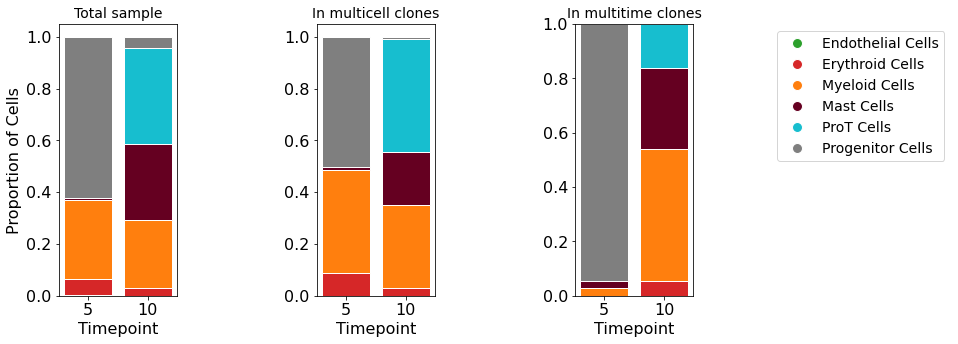

In [46]:
# Compare the cell censuses visually
fig = plt.figure(figsize=(16,5))
# plt.suptitle("Cell Census", fontweight='bold')
fig.tight_layout()
gs = fig.add_gridspec(1, 14)
i = 1


for k in census_dfs:
    plt.subplot(gs[:, 4*(i-1):4*i-2])
    baseline = np.zeros(2)
    plt.xlabel('Timepoint')
    
    # Just plot labels once
    if i == 1:
        plt.ylabel('Proportion of Cells')
    elif i == 3:
        plt.xlabel('Timepoint')
    
    # Plot the cell census
    plt.title("{}".format(k), fontsize=14)
    plt.xticks(range(2), [t1, t2])
    data = census_dfs[k]
    data = data.divide(data.sum(axis=1), axis="rows")
    for lin in data.columns:
        plt.bar(range(2), data.loc[:, lin], facecolor=celltype_color[lin], edgecolor='w', label=lin, bottom=baseline)
        baseline = baseline + data.loc[:, lin]
    i += 1

# Plot the legend
plt.subplot(gs[:, -1])
plt.axis('off')
plt.legend(handles=celltype_legend_handles, fontsize=14)

plt.show()

### Run many resampling simulations and plot the cell type proportions as a line graph

In [47]:
# Simulation parameters
n_simulations = 10
sampling_rates = np.round(np.linspace(0.05, 1.0, 10)[::-1], decimals=2)

In [48]:
# Simulate the sampling process at the specified rates
randomly_sampled_adatas = {}
MT_adatas = {} 

for x in range(n_simulations):
    sim_key = str(x)
    randomly_sampled_adatas[sim_key] = {}
    MT_adatas[sim_key] = {}
    
    for s in sampling_rates:
        rate_key = str(s*100) + "%"
        temp_random = src.randomly_sample_timepoints(population_adatas['Total sample'], times, s)
        randomly_sampled_adatas[sim_key][rate_key] = temp_random
        MT_adatas[sim_key][rate_key] = src.retain_multitime_only(temp_random, times, clone_idx)

In [49]:
# Create a cell census dataframe for the two timepoints
census_dfs = {}
for x in range(n_simulations):
    sim_key = str(x)
    census_dfs[sim_key] = {}
    
    for r in sampling_rates:
        rate_key = str(r*100) + "%"
        census_dfs[sim_key][rate_key] = pd.DataFrame({'A': [],'B': [], 'AB': []})

        for t in times:
            data = MT_adatas[sim_key][rate_key].obs[MT_adatas[sim_key][rate_key].obs.Order == t]
            if data.shape[0] == 0:
                census_dfs[sim_key][rate_key] = census_dfs[sim_key][rate_key].append({'Order': t, 
                                          'Endothelial Cells': 0, 
                                          'Erythroid Cells': 0, 
                                          'Myeloid Cells': 0,
                                          'Mast Cells': 0, 
                                          'ProT Cells': 0, 
                                          'Progenitor Cells': 0},
                                        ignore_index = True)
            else:
                census_dfs[sim_key][rate_key] = census_dfs[sim_key][rate_key].append({'Order': t, 
                                          'Endothelial Cells': data[data['Cell Types'] == 'Endothelial Cells'].shape[0]/data.shape[0], 
                                          'Erythroid Cells': data[data['Cell Types'] == 'Erythroid Cells'].shape[0]/data.shape[0], 
                                          'Myeloid Cells': data[data['Cell Types'] == 'Myeloid Cells'].shape[0]/data.shape[0],
                                          'Mast Cells': data[data['Cell Types'] == 'Mast Cells'].shape[0]/data.shape[0], 
                                          'ProT Cells': data[data['Cell Types'] == 'ProT Cells'].shape[0]/data.shape[0], 
                                          'Progenitor Cells': data[data['Cell Types'] == 'Progenitor Cells'].shape[0]/data.shape[0]},
                                        ignore_index = True)

        census_dfs[sim_key][rate_key] = census_dfs[sim_key][rate_key].set_index('Order')

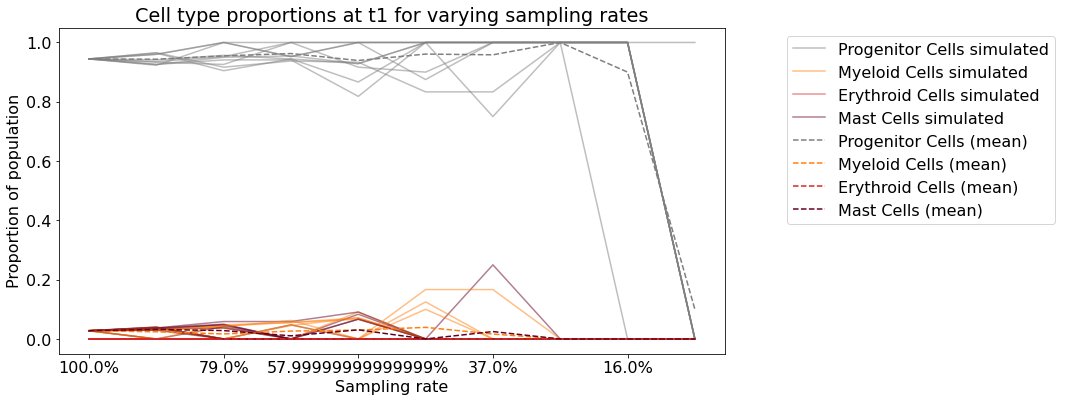

In [57]:
# Plot the cell census at different sampling rates
# against the predicted proportions
sample_keys = [str(r*100) + "%" for r in sampling_rates]
cell_types = list(temp_adata_t1.obs['Cell Types'].unique())
sum_z_t1 = np.zeros((len(cell_types), len(sampling_rates)))

fig = plt.figure(figsize=(18,6))
fig.tight_layout()
gs = fig.add_gridspec(1, 18)
ax = plt.subplot(gs[:, :12])
plt.title("Cell type proportions at t1 for varying sampling rates")
plt.ylabel("Proportion of population")
plt.xlabel("Sampling rate")

for x in range(n_simulations):
    sim_key = str(x)
    z_t1 = np.zeros((len(cell_types), len(sampling_rates)))
    p_type_given_MT = np.zeros((len(cell_types), len(sampling_rates)))
    
    # Computing cell type proportions and probabilities
    for i in range(len(sampling_rates)):
        rate_key = sample_keys[i]
        z_t1[:, i] = list(census_dfs[sim_key][rate_key].loc[t1][c] for c in cell_types)
        
        p_dict = src.probability_cell_of_type_given_multitime(
            population_adatas['Total sample'], times, sampling_rates[i], sampling_rates[i])
        for j in range(len(cell_types)):
            t = cell_types[j]
            if t in p_dict.keys():
                p_type_given_MT[j, i] = p_dict[t]

    # Sum the census proportions to compute the mean later
    sum_z_t1 = sum_z_t1 + z_t1
    
    # Plotting
    if x == n_simulations-1:
        locs, labels = plt.xticks()  # Get the current locations and labels.
        plt.xticks(np.arange(len(sample_keys), step=2), sample_keys[::2])  # Set text labels
   
        for i in range(len(cell_types)):
            t = cell_types[i]
            if t == 'ProT Cells' or t == 'Endothelial Cells':
                pass
            else:
                plt.plot(z_t1[i], label=t + ' simulated', color=celltype_color[t], alpha=0.5)
#                 plt.plot(p_type_given_MT[i], label=c + ' predicted', color=celltype_color[t], ls="-.")
    else:
        for i in range(len(cell_types)):
            t = cell_types[i]
            if t == 'ProT Cells' or t == 'Endothelial Cells':
                pass
            else:
                plt.plot(z_t1[i], color=celltype_color[t], alpha=0.5)
#                 plt.plot(p_type_given_MT[i], color=celltype_color[t], ls="-.")


# Plot the mean for each cell type across the simulations
mean_z_t1 = sum_z_t1/n_simulations
for i in range(len(cell_types)):
    t = cell_types[i]
    if t == 'ProT Cells' or t == 'Endothelial Cells':
        pass
    else:
        plt.plot(mean_z_t1[i], label=t + ' (mean)', color=celltype_color[t], linestyle='--')

handles, _ = ax.get_legend_handles_labels()
plt.subplot(gs[:, -1:])
plt.axis('off')
plt.legend(handles=handles, loc='upper right')
plt.show()